In [1]:
DATA_DIR = '/media/HDD1/data/atari_v2/atari_v2_release/'

In [2]:
import agc.dataset as dataset
import agc.util as util

import numpy as np

from os import path, listdir

import cv2

from IPython.display import display, HTML
from prettytable import PrettyTable

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
dataset = dataset.AtariDataset(DATA_DIR)

In [4]:
titles = [' '] + [util.TITLES[g] for g in util.GAMES]

table = PrettyTable(titles)
table.align[''] = "l"
table.align[''] = "l"

row = ['episodes']
for g in util.GAMES:
    row.append(dataset.stats[g]['total_replays'])
table.add_row(row)

row = ['frames']
for g in util.GAMES:
    row.append(dataset.stats[g]['total_frames'])
table.add_row(row)
  
row = ['hours of gameplay']
for g in util.GAMES:
    hrs = float(dataset.stats[g]['total_frames']//60//60/60)
    row.append('%.2f' % (hrs,))
table.add_row(row)

row = ['worst score']
for g in util.GAMES:
    row.append(dataset.stats[g]['min_score'])
table.add_row(row)

row = ['best score']
for g in util.GAMES:
    row.append(dataset.stats[g]['max_score'])
table.add_row(row)

row = ['average score']
for g in util.GAMES:
    row.append("%.0f" % dataset.stats[g]['avg_score'])
table.add_row(row)

row = ['score SEM']
for g in util.GAMES:
    row.append("%.0f" % dataset.stats[g]['sem'])
table.add_row(row)
    
row = ['score stddev']
for g in util.GAMES:
    row.append("%.0f" % dataset.stats[g]['stddev'])
table.add_row(row)

    
display(HTML(table.get_html_string()))

,Space Invaders,Q*bert,Ms. Pacman,Video Pinball,Montezumas's Revenge
episodes,905,1136,667,380,1196
frames,4005345,3329088,2829068,2352787,4623879
hours of gameplay,18.53,15.40,13.08,10.88,21.40
worst score,5,25,10,1,100
best score,3260,35675,20241,49345,10000
average score,635,3440,3041,9876,946
score SEM,14,183,124,446,39
score stddev,429,6170,3206,8683,1340


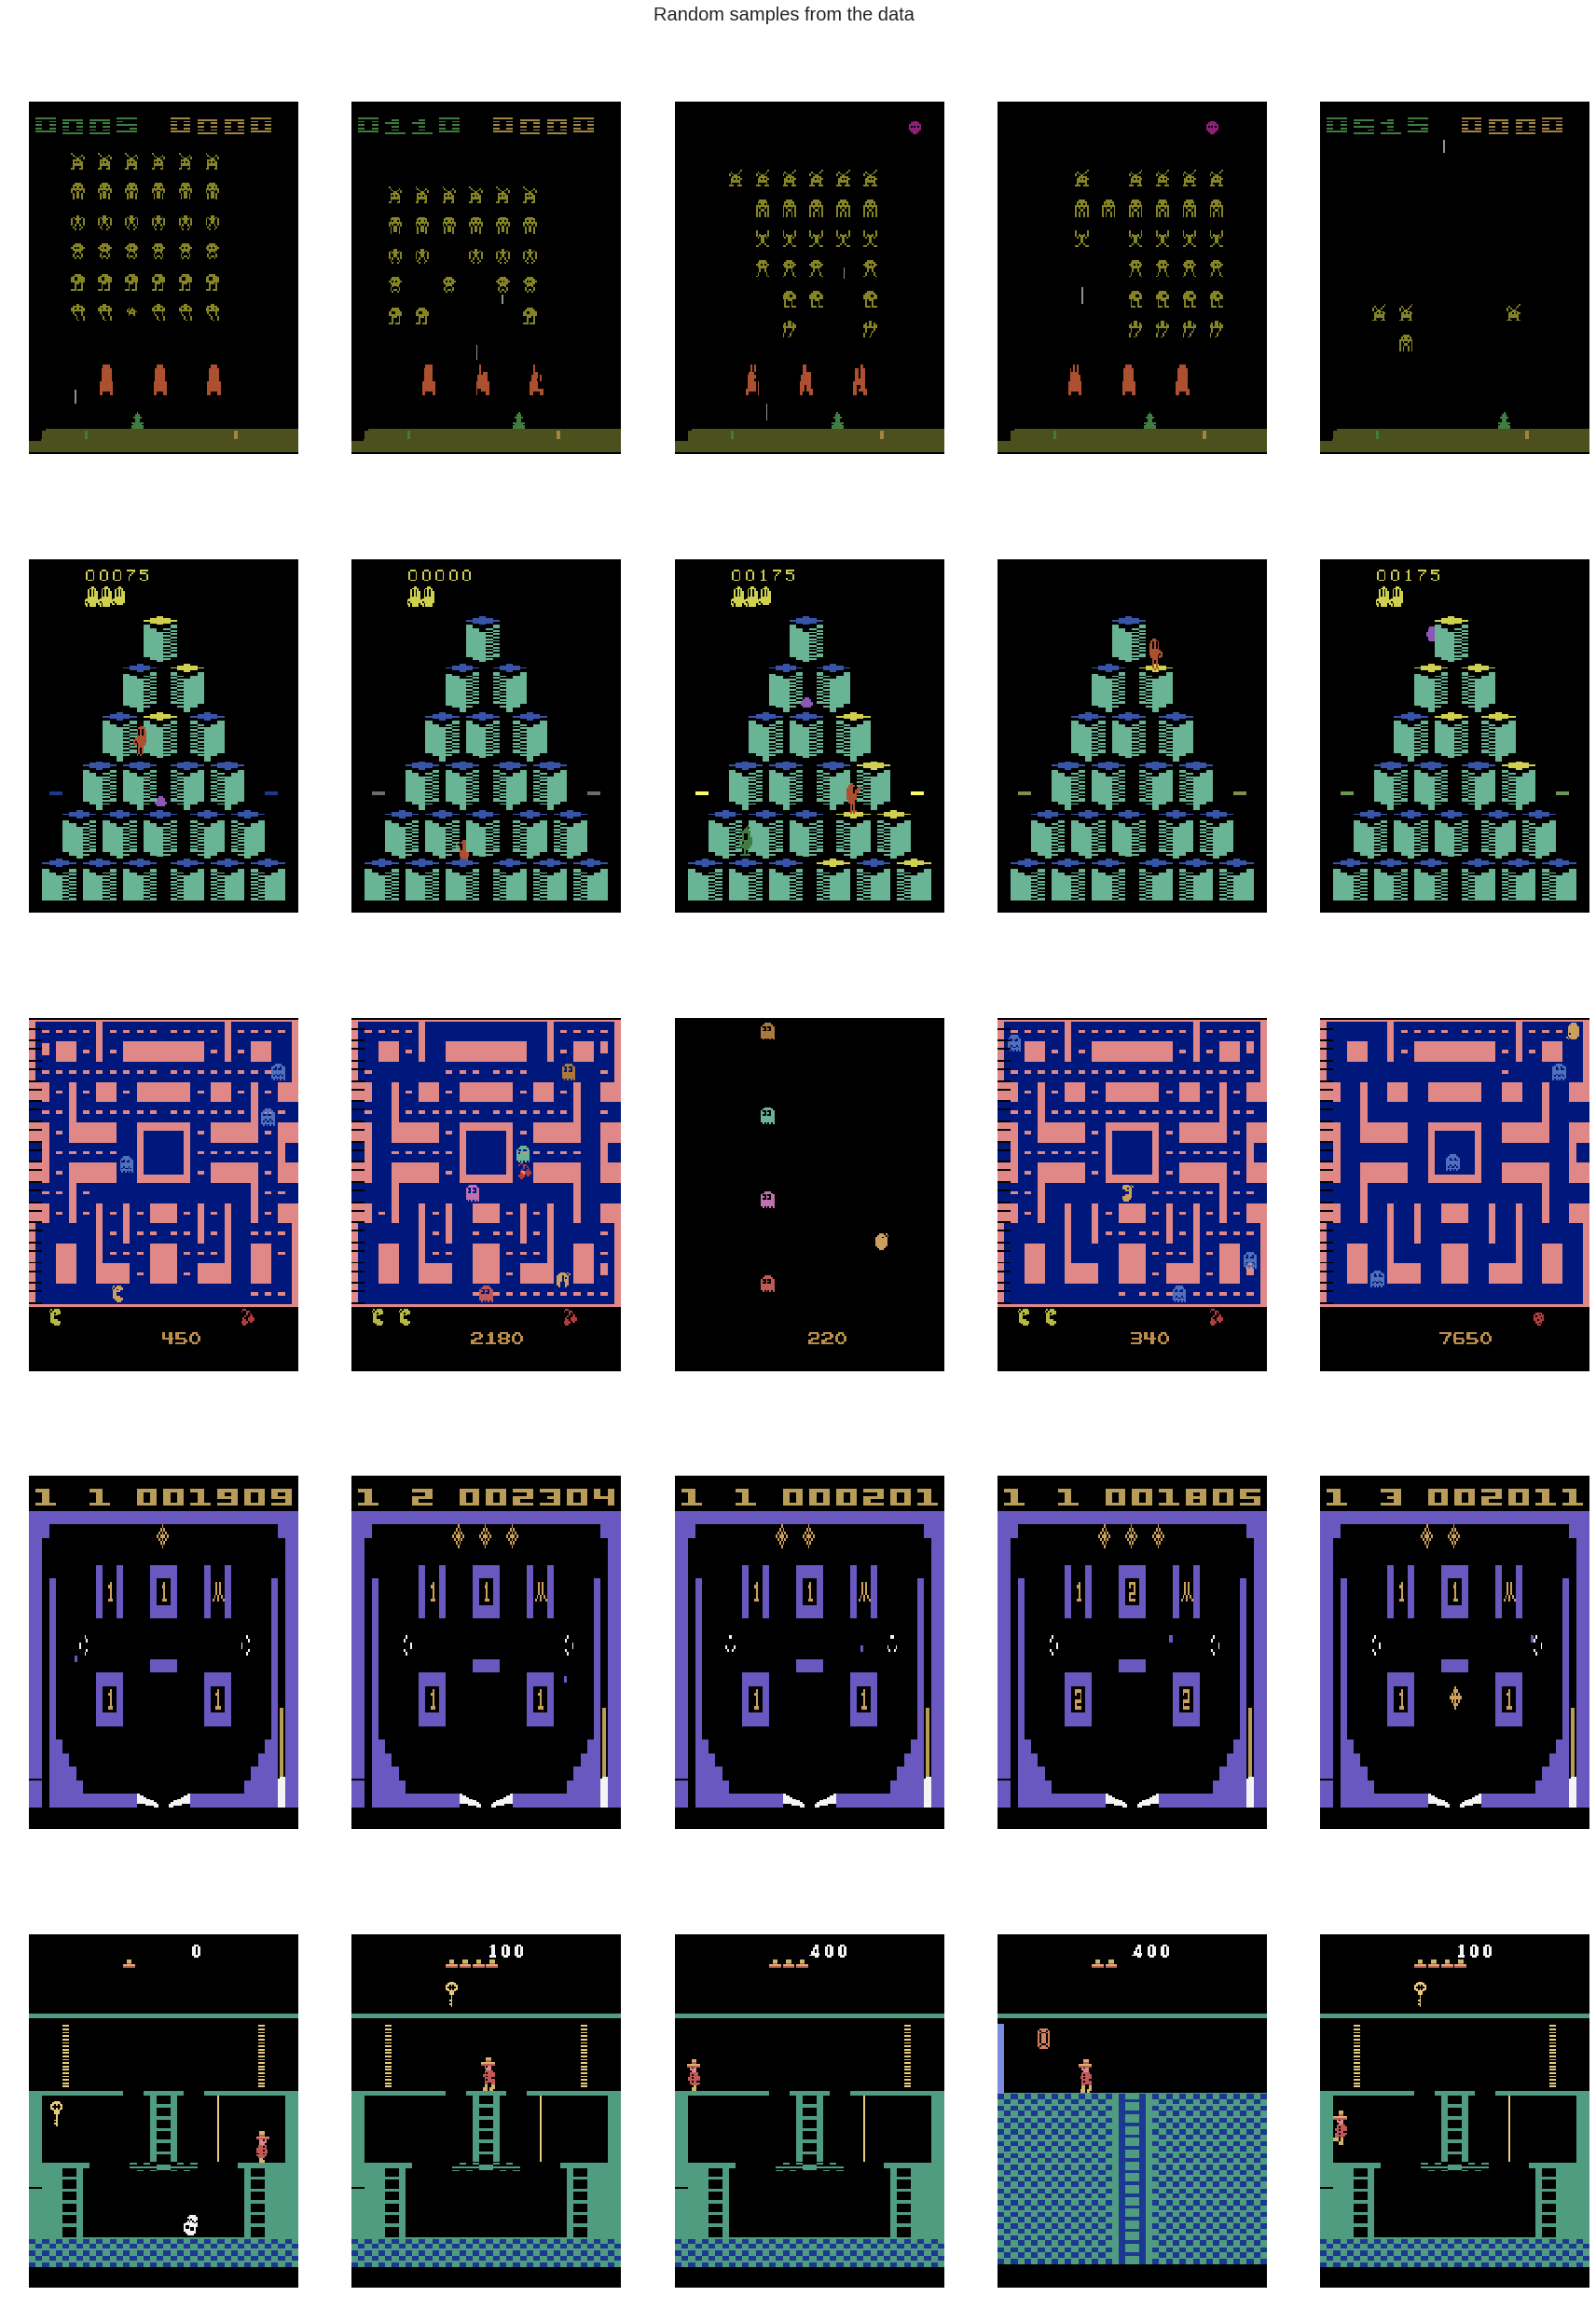

In [5]:
f = plt.gcf()
plt.suptitle('Random samples from the data', fontsize=20)
plt.subplots_adjust(top=0.95)
f.set_figheight(40)
f.set_figwidth(30)
for k, g in enumerate(util.GAMES):
    screens_dir = path.join(DATA_DIR, 'screens', g)
    for i in range(5):
        sample_traj = path.join(screens_dir, np.random.choice(listdir(screens_dir)))
        sample_pic = np.random.choice(listdir(sample_traj))
        pic = cv2.imread(path.join(sample_traj, sample_pic))
        plt.subplot(5,5,5*k+i+1)
        plt.imshow(cv2.cvtColor(pic, cv2.COLOR_BGR2RGB))
        plt.axis('off');

In [6]:
# compute some stats on top

final_scores = {}
frames_played = {}
sec_vs_finscore = {}
terminals = {}
actions =  {}

for g in util.GAMES:
    final_scores[g]    = []
    frames_played[g]   = []
    sec_vs_finscore[g] = []
    terminals[g]       = []
    actions[g]         = []

    for t in dataset.trajectories[g]:
        cfs = dataset.trajectories[g][t][-1]['score']
        final_scores[g].append(cfs)
        cfp = len(dataset.trajectories[g][t])
        frames_played[g].append(cfp)
        sec_vs_finscore[g].append([cfp/60, cfs])
        terminals[g].append(dataset.trajectories[g][t][-1]['terminal'])
        actions[g].append([ct['action'] for ct in dataset.trajectories[g][t]])

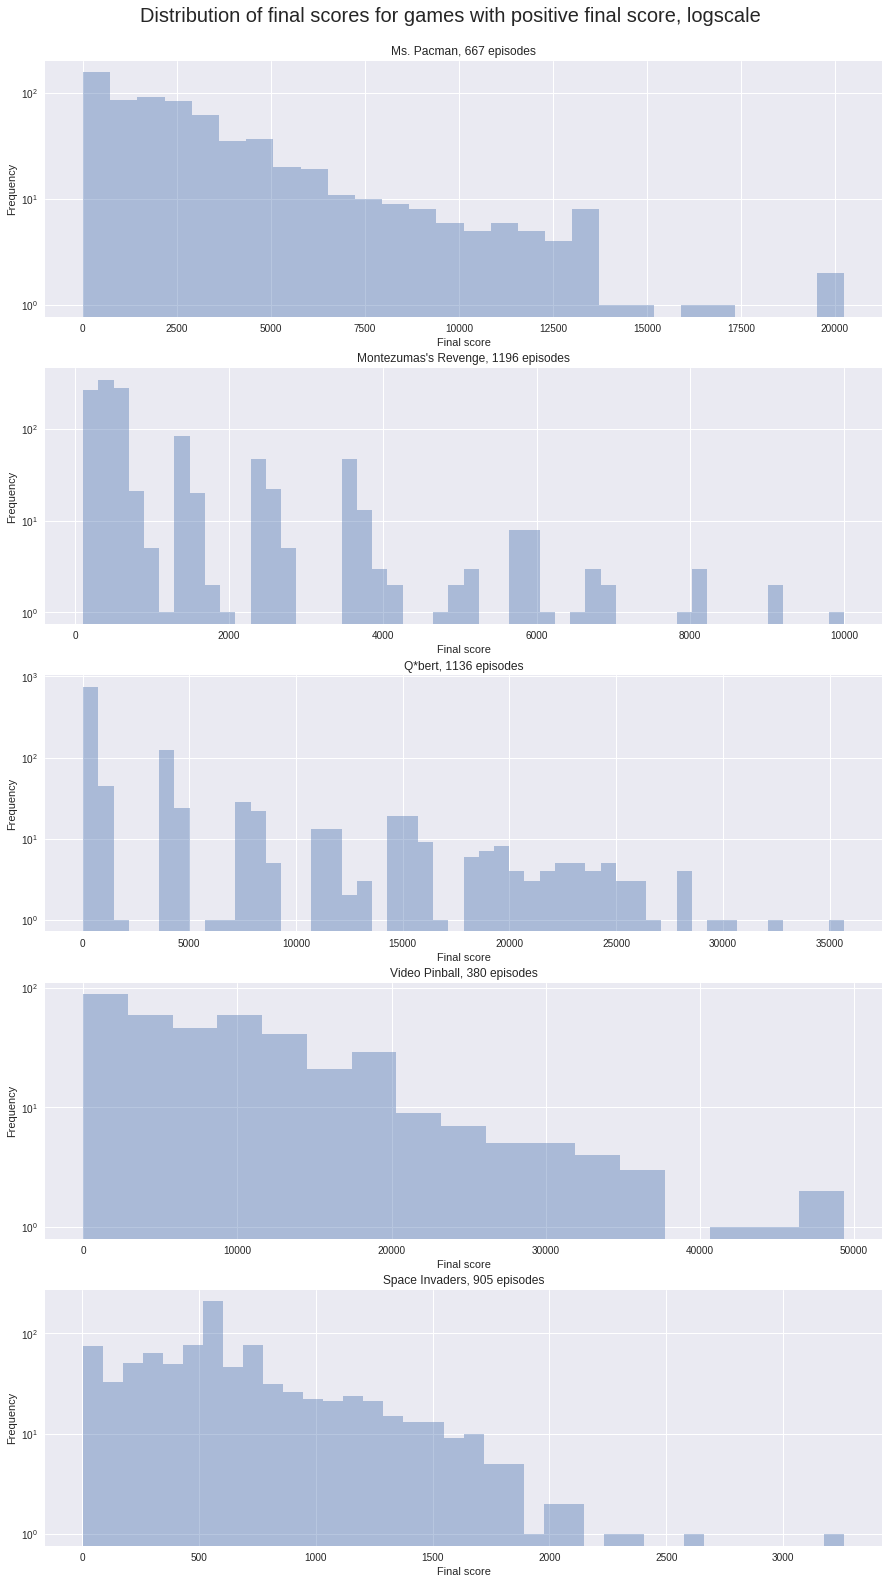

In [7]:
f, axes = plt.subplots(5, figsize=(15,25))
plt.subplots_adjust(top=0.95)
plt.suptitle('Distribution of final scores for games with positive final score, logscale', fontsize=20)
for i,g in enumerate(final_scores):
    cax = axes[i]
    cax.set_title("%s, %d episodes" % (util.TITLES[g], dataset.stats[g]['total_replays']))
    sns.distplot(final_scores[g], ax=cax, kde=False)
    cax.set_xlabel('Final score')
    cax.set_ylabel('Frequency')
    cax.set_yscale('log')

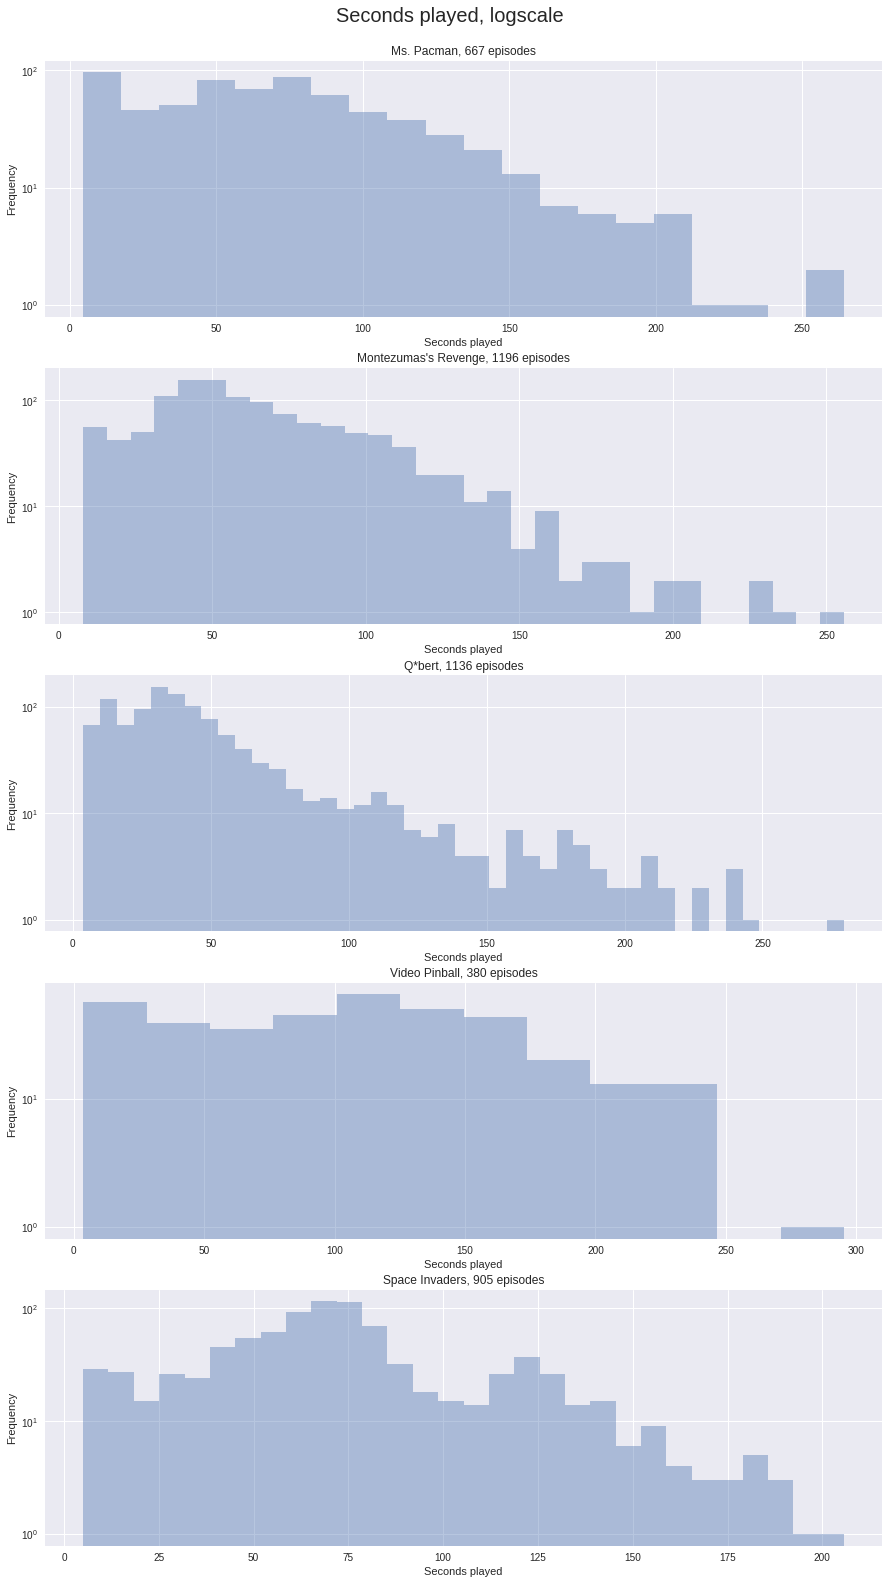

In [8]:
f, axes = plt.subplots(5, figsize=(15,25))
plt.subplots_adjust(top=0.95)
f.suptitle("Seconds played, logscale", fontsize=20)
for i,g in enumerate(frames_played):
    cax = axes[i]
    cax.set_title("%s, %d episodes" % (util.TITLES[g], dataset.stats[g]['total_replays']))
    sns.distplot([el/60 for el in frames_played[g]], ax=cax, kde=False)
    cax.set_xlabel('Seconds played')
    cax.set_ylabel('Frequency')
    cax.set_yscale('log')

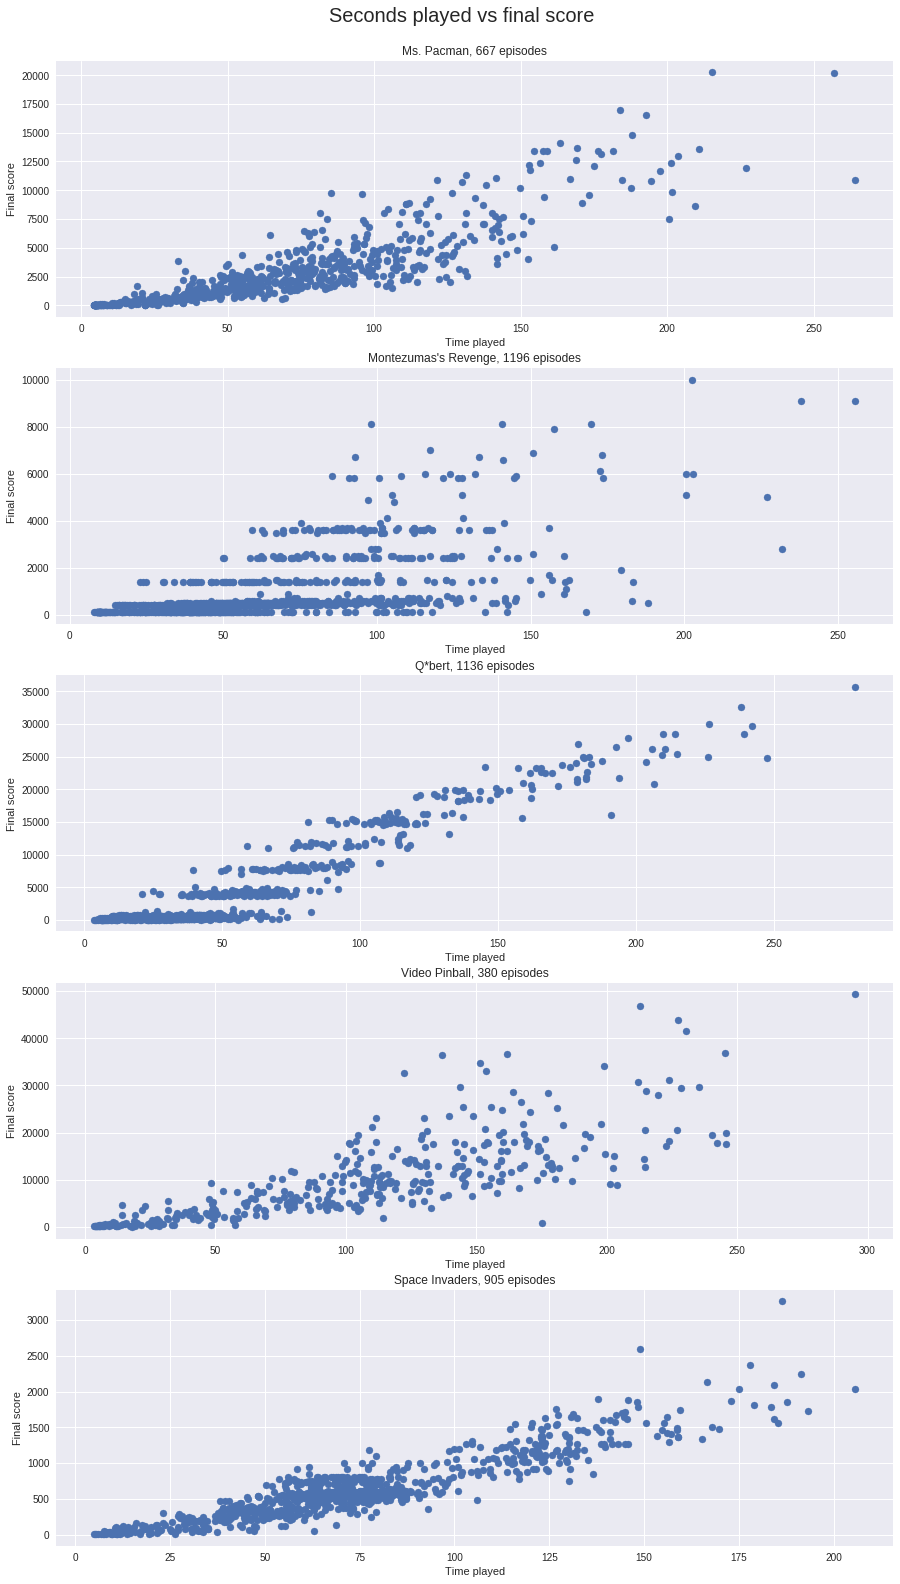

In [9]:
f, axes = plt.subplots(5, figsize=(15,25))
plt.subplots_adjust(top=0.95)
f.suptitle("Seconds played vs final score", fontsize=20)
for i,g in enumerate(sec_vs_finscore):
    cax = axes[i]
    cax.set_title("%s, %d episodes" % (util.TITLES[g], dataset.stats[g]['total_replays']))
    #sns.distplot([el/60 for el in frames_played[g]], bins = 100, ax=cax)
    data = np.array(sec_vs_finscore[g])
    cax.scatter(data[:,0], data[:,1])
    cax.set_xlabel('Time played')
    cax.set_ylabel('Final score')

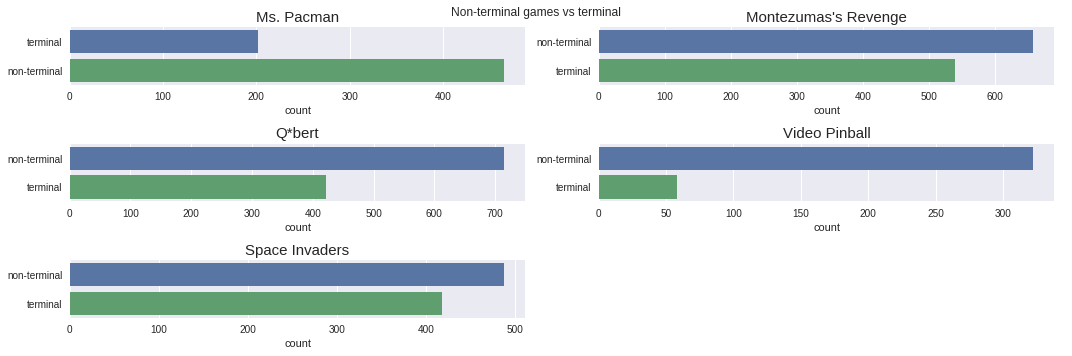

In [10]:
f, axes = plt.subplots(3,2, figsize=(15,5))
plt.subplots_adjust(top=0.9)
f.suptitle("Non-terminal games vs terminal")
for i,g in enumerate(terminals):
    cax = axes[i//2][i%2]
    cax.set_title("%s" % (util.TITLES[g]), fontsize=15)
    sns.countplot(y=['terminal' if s == 1 else 'non-terminal'for s in terminals[g]], ax=cax)
    plt.tick_params(axis='x', labelsize=16)
    plt.tick_params(axis='y', labelsize=16)
axes[-1][-1].axis('off')

plt.tight_layout()

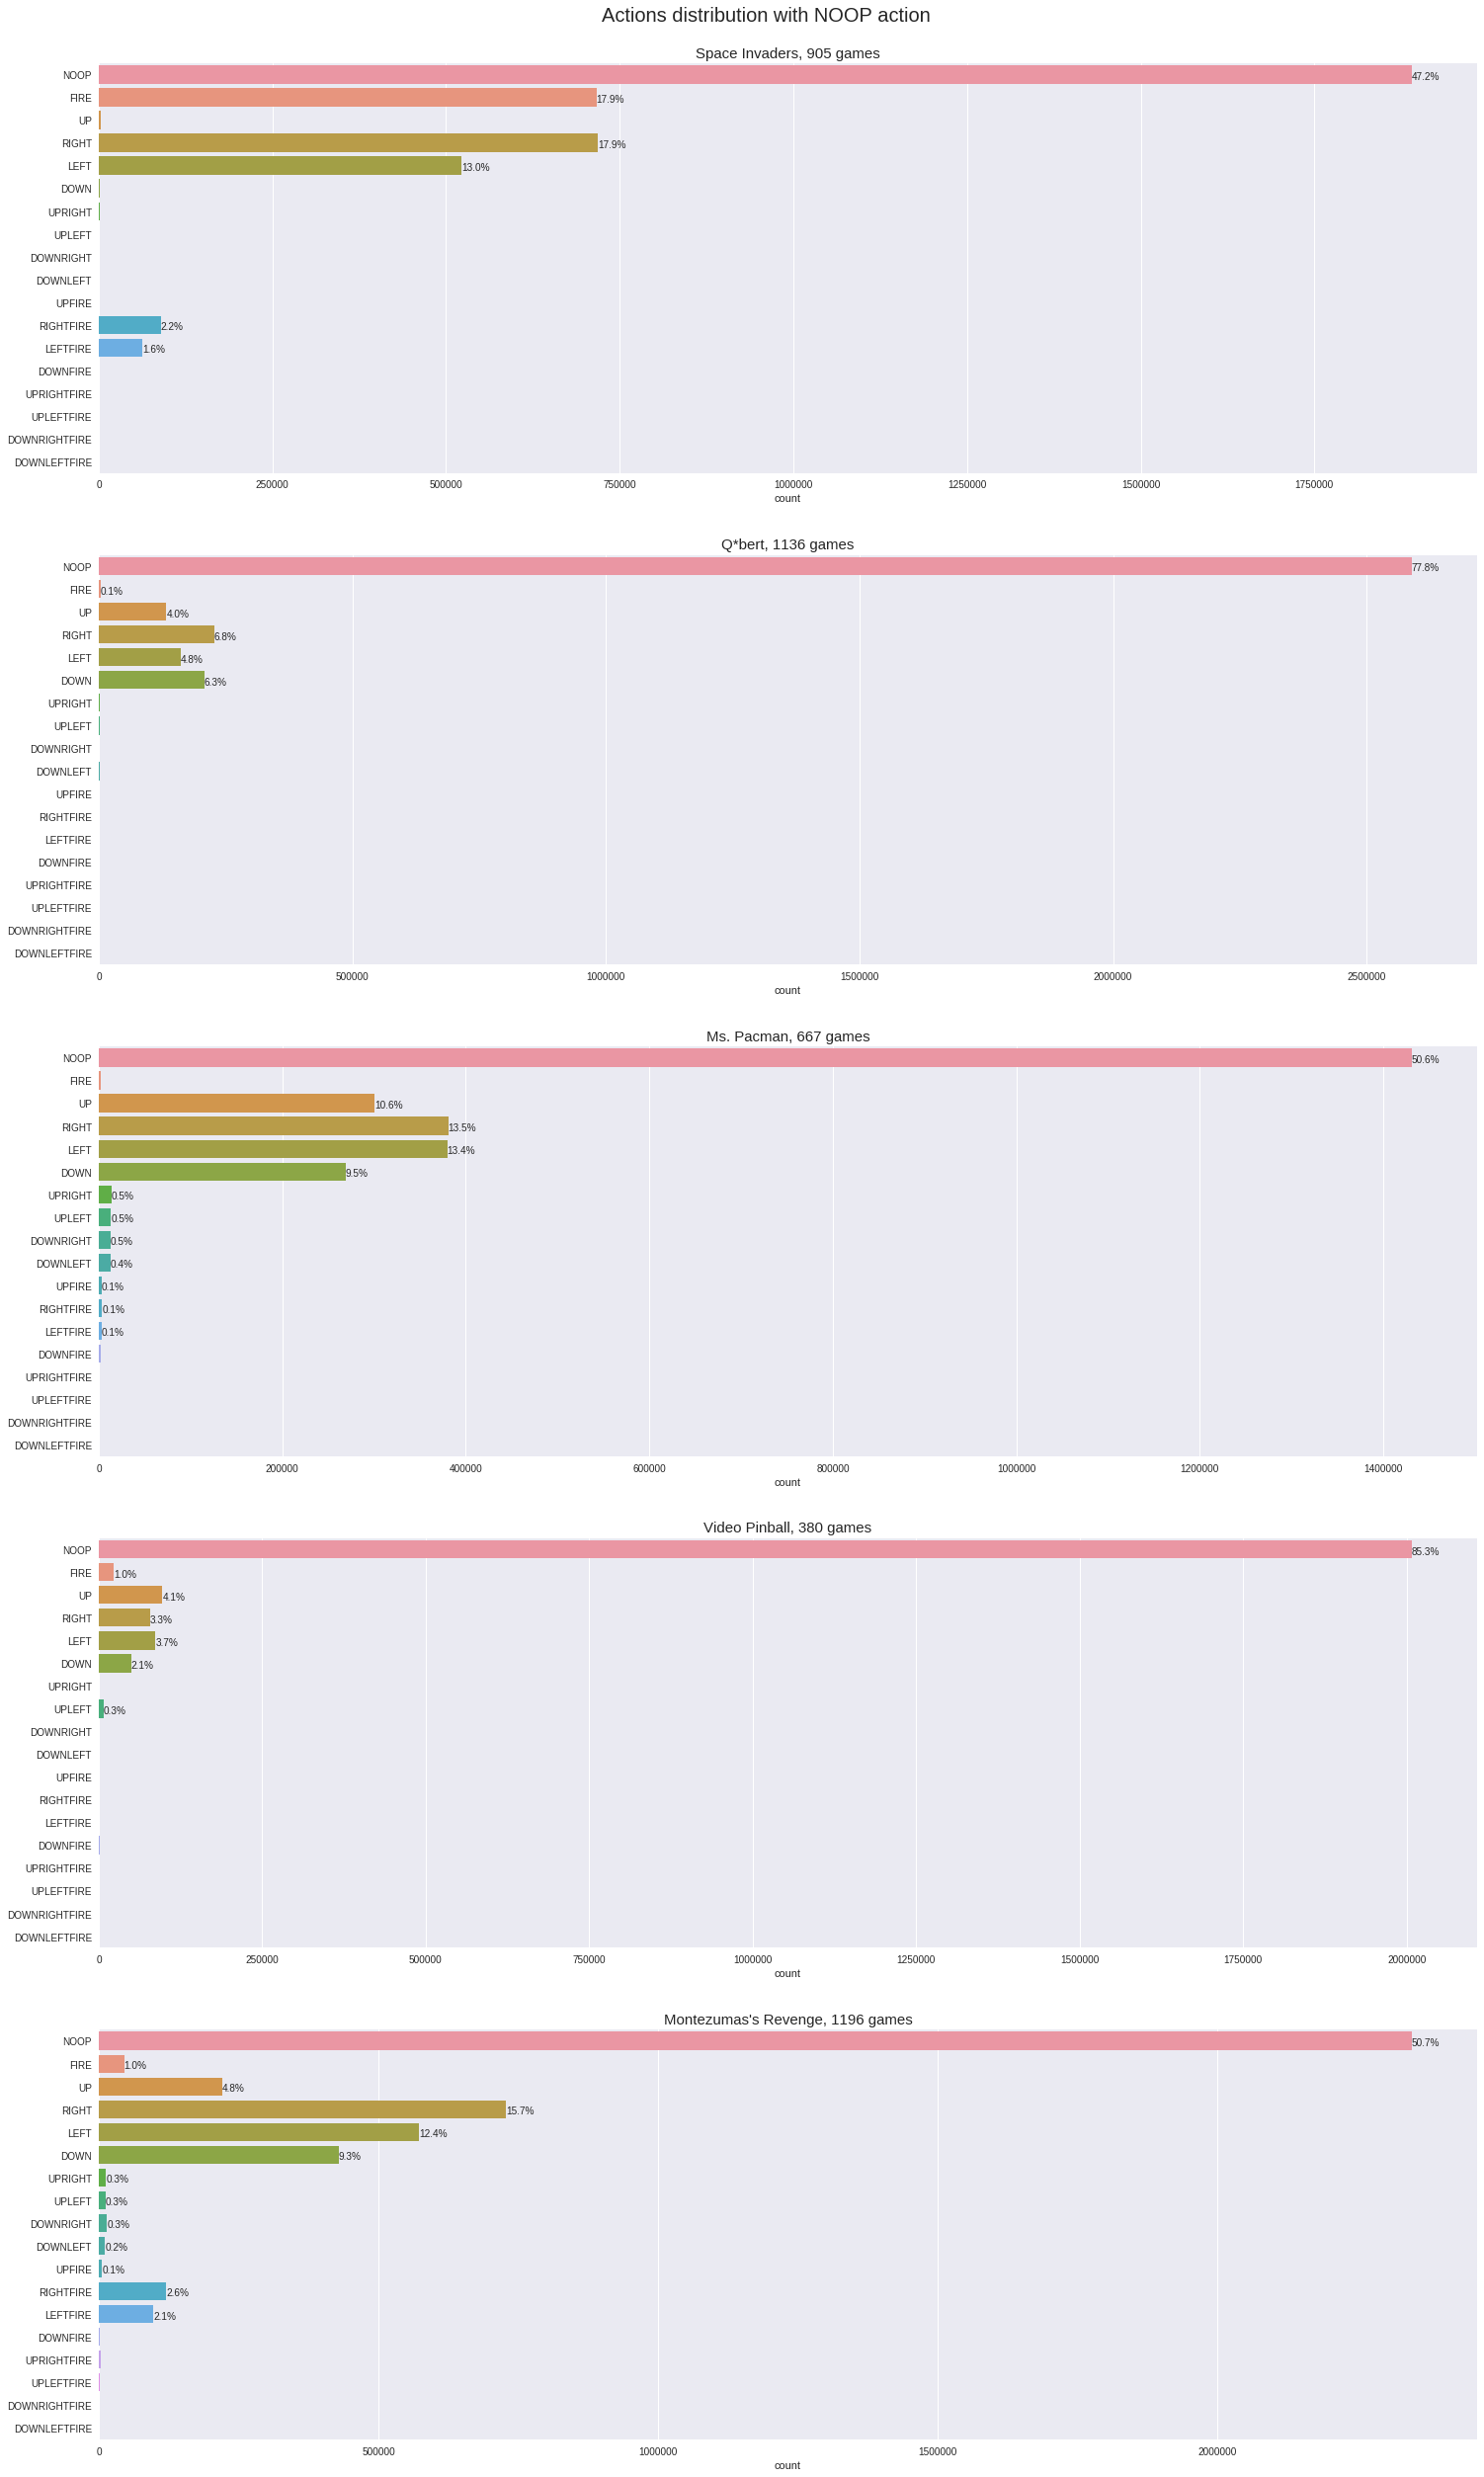

In [11]:
f, axes = plt.subplots(5, figsize=(25,40))
plt.subplots_adjust(top=0.96)
f.suptitle("Actions distribution with NOOP action", fontsize=20)
for i,g in enumerate(util.GAMES):
    data = [util.ACTIONS[s] for el in actions[g] for s in el]
    cax = axes[i]
    cax.set_title(util.TITLES[g],fontsize=25)
    cax.set_title("%s, %d games" % (util.TITLES[g], dataset.stats[g]['total_replays']), fontsize=15)
    sns.countplot(y=data,order=util.ACTIONS, ax=cax)

    for p in cax.patches:
        percentage = 100*p.get_width()/len(data)
        if percentage > 0.1:
            cax.annotate('{:.1f}%'.format(percentage), (p.get_width()+1.5, p.get_y()+0.6))

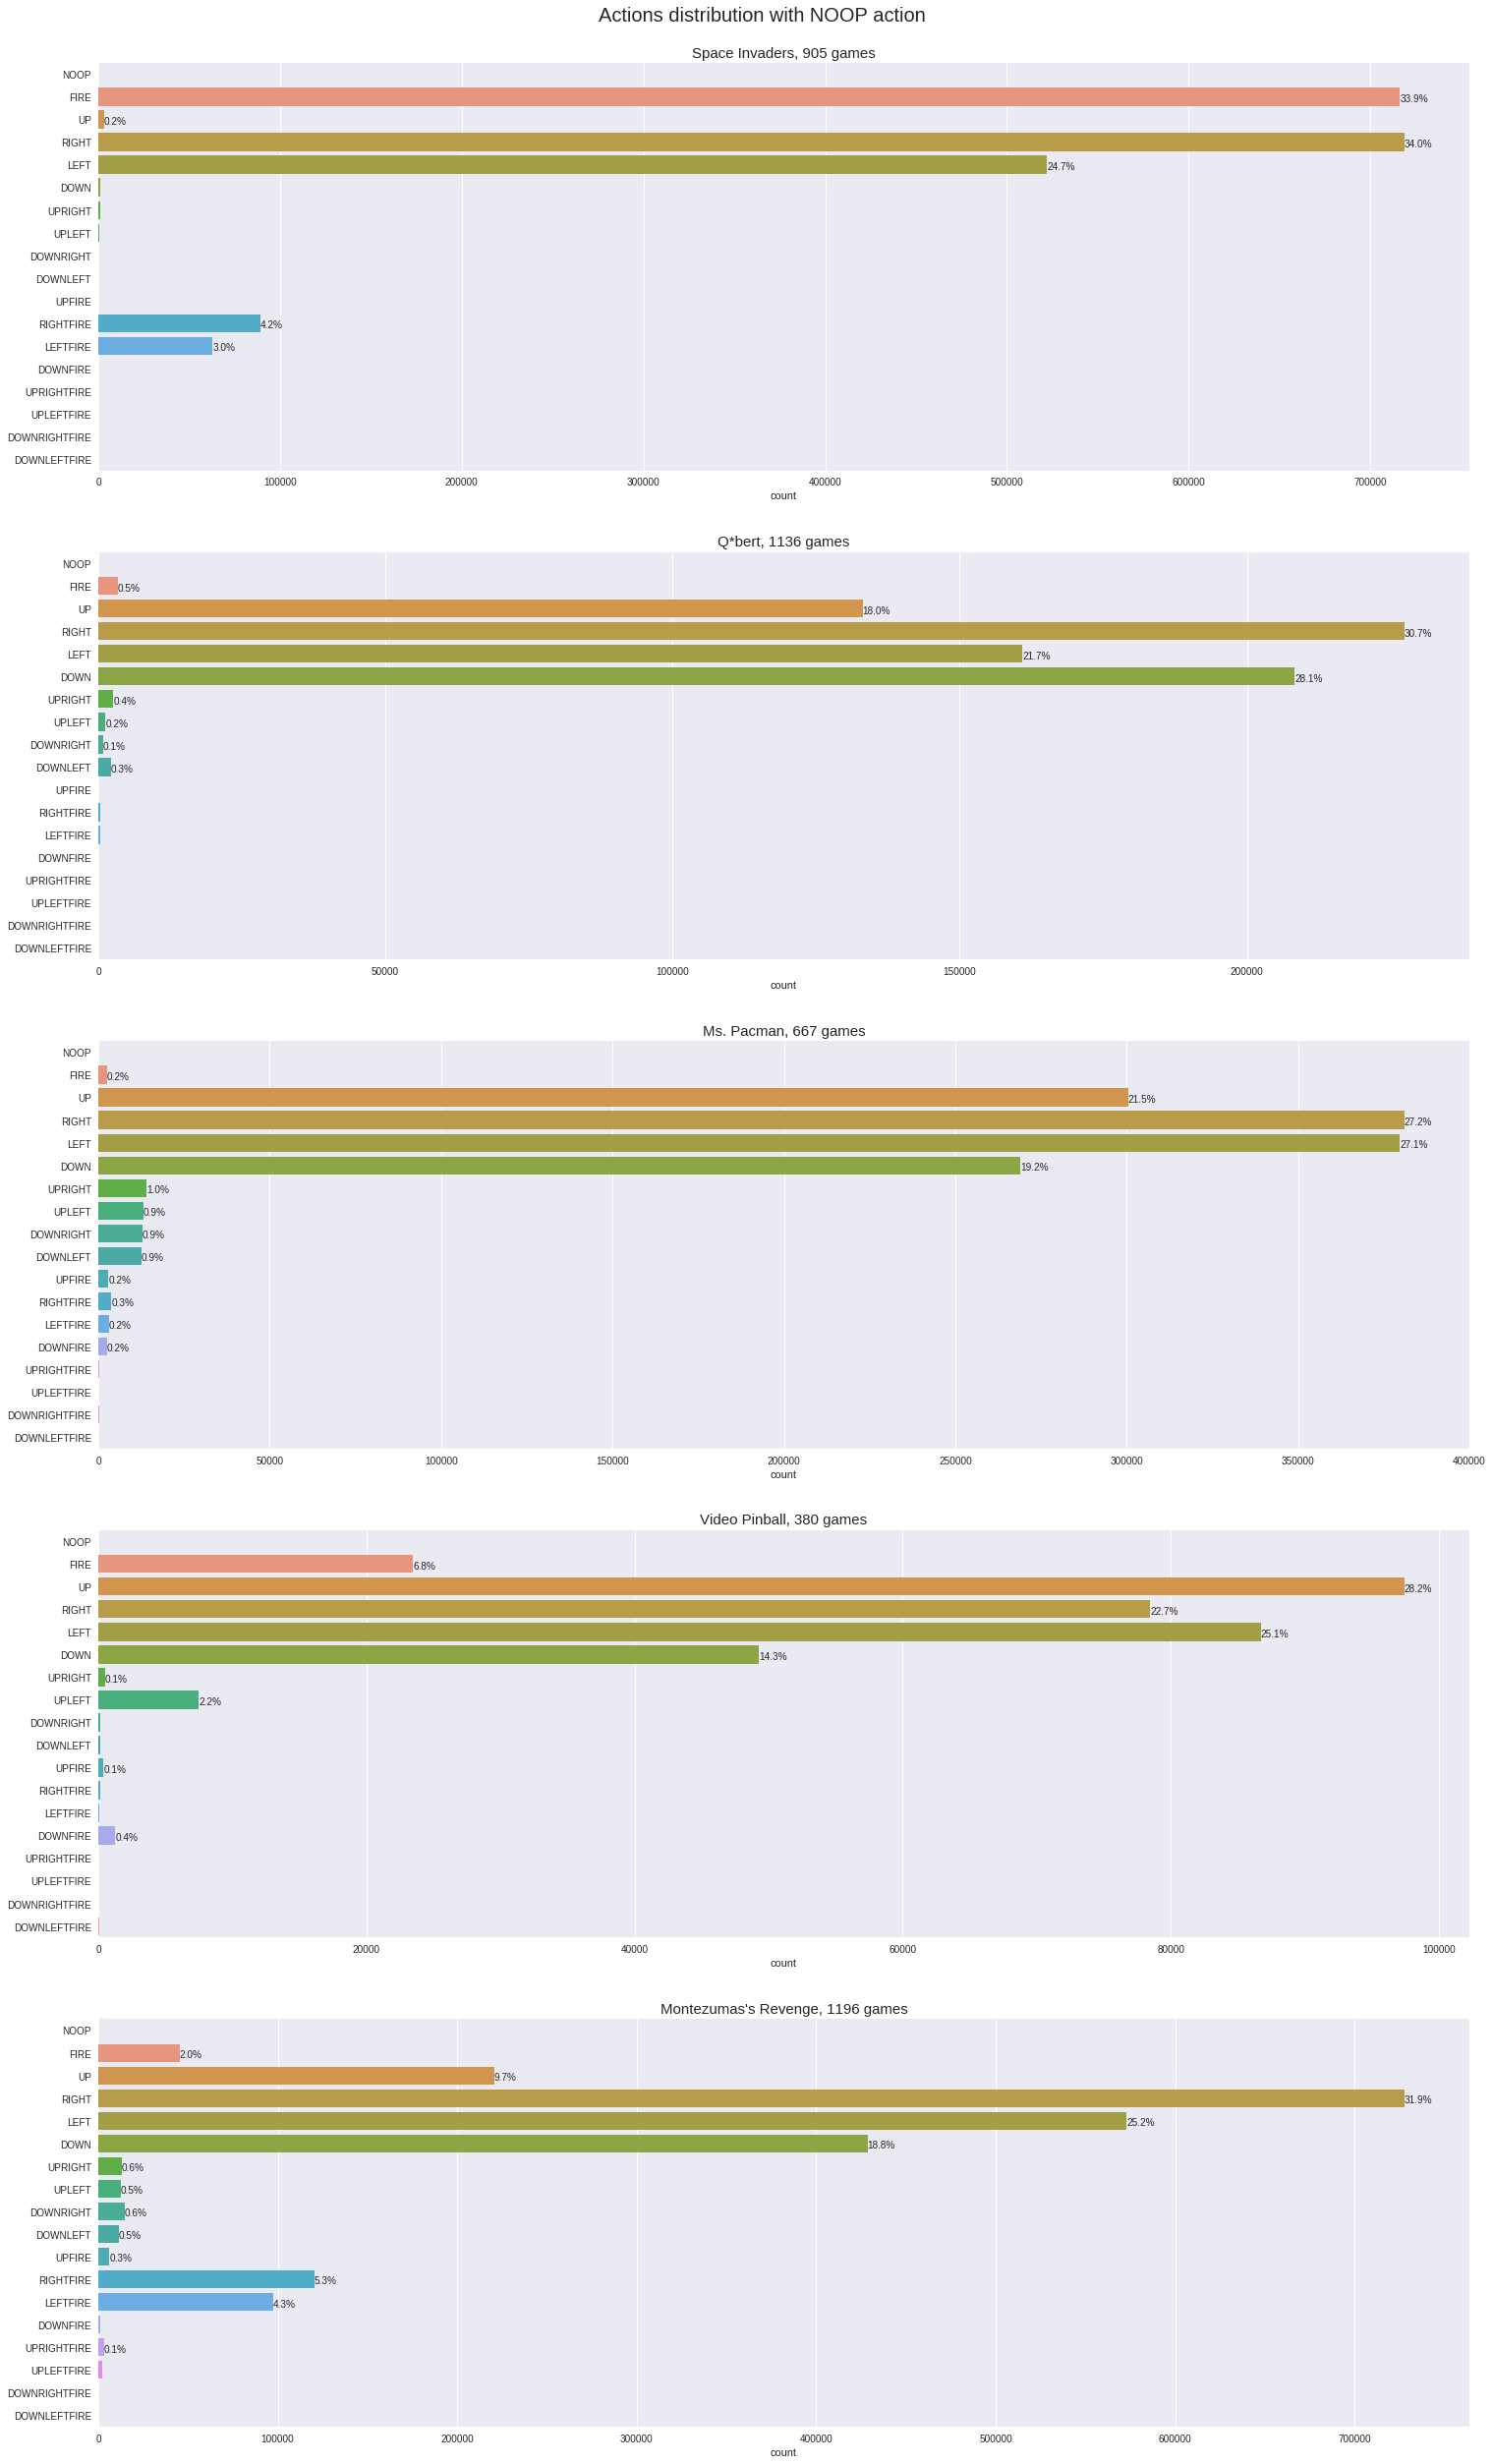

In [12]:
f, axes = plt.subplots(5, figsize=(25,40))
plt.subplots_adjust(top=0.96)
f.suptitle("Actions distribution with NOOP action", fontsize=20)
for i,g in enumerate(util.GAMES):
    data = [util.ACTIONS[s] for el in actions[g] for s in el if s != 0]
    cax = axes[i]
    cax.set_title(util.TITLES[g],fontsize=25)
    cax.set_title("%s, %d games" % (util.TITLES[g], dataset.stats[g]['total_replays']), fontsize=15)
    sns.countplot(y=data,order=util.ACTIONS, ax=cax)

    for p in cax.patches:
        percentage = 100*p.get_width()/len(data)
        if percentage > 0.1:
            cax.annotate('{:.1f}%'.format(percentage), (p.get_width()+1.5, p.get_y()+0.6))

In [13]:
def action_splitter(arr):
    '''splits array for chunks of same sequential symbols'''
    if len(arr) < 2:
        return [arr]
    idx_arr = []
    for i in range(1, len(arr)):
        if arr[i] != arr[i-1]:
            idx_arr.append(i)
    return [el.tolist() for el in np.split(arr, idx_arr)]

# safety check
a = [0]
print(action_splitter(a))
a = [0,0,1,0,1,1,2]
print(action_splitter(a))

[[0]]
[[0, 0], [1], [0], [1, 1], [2]]


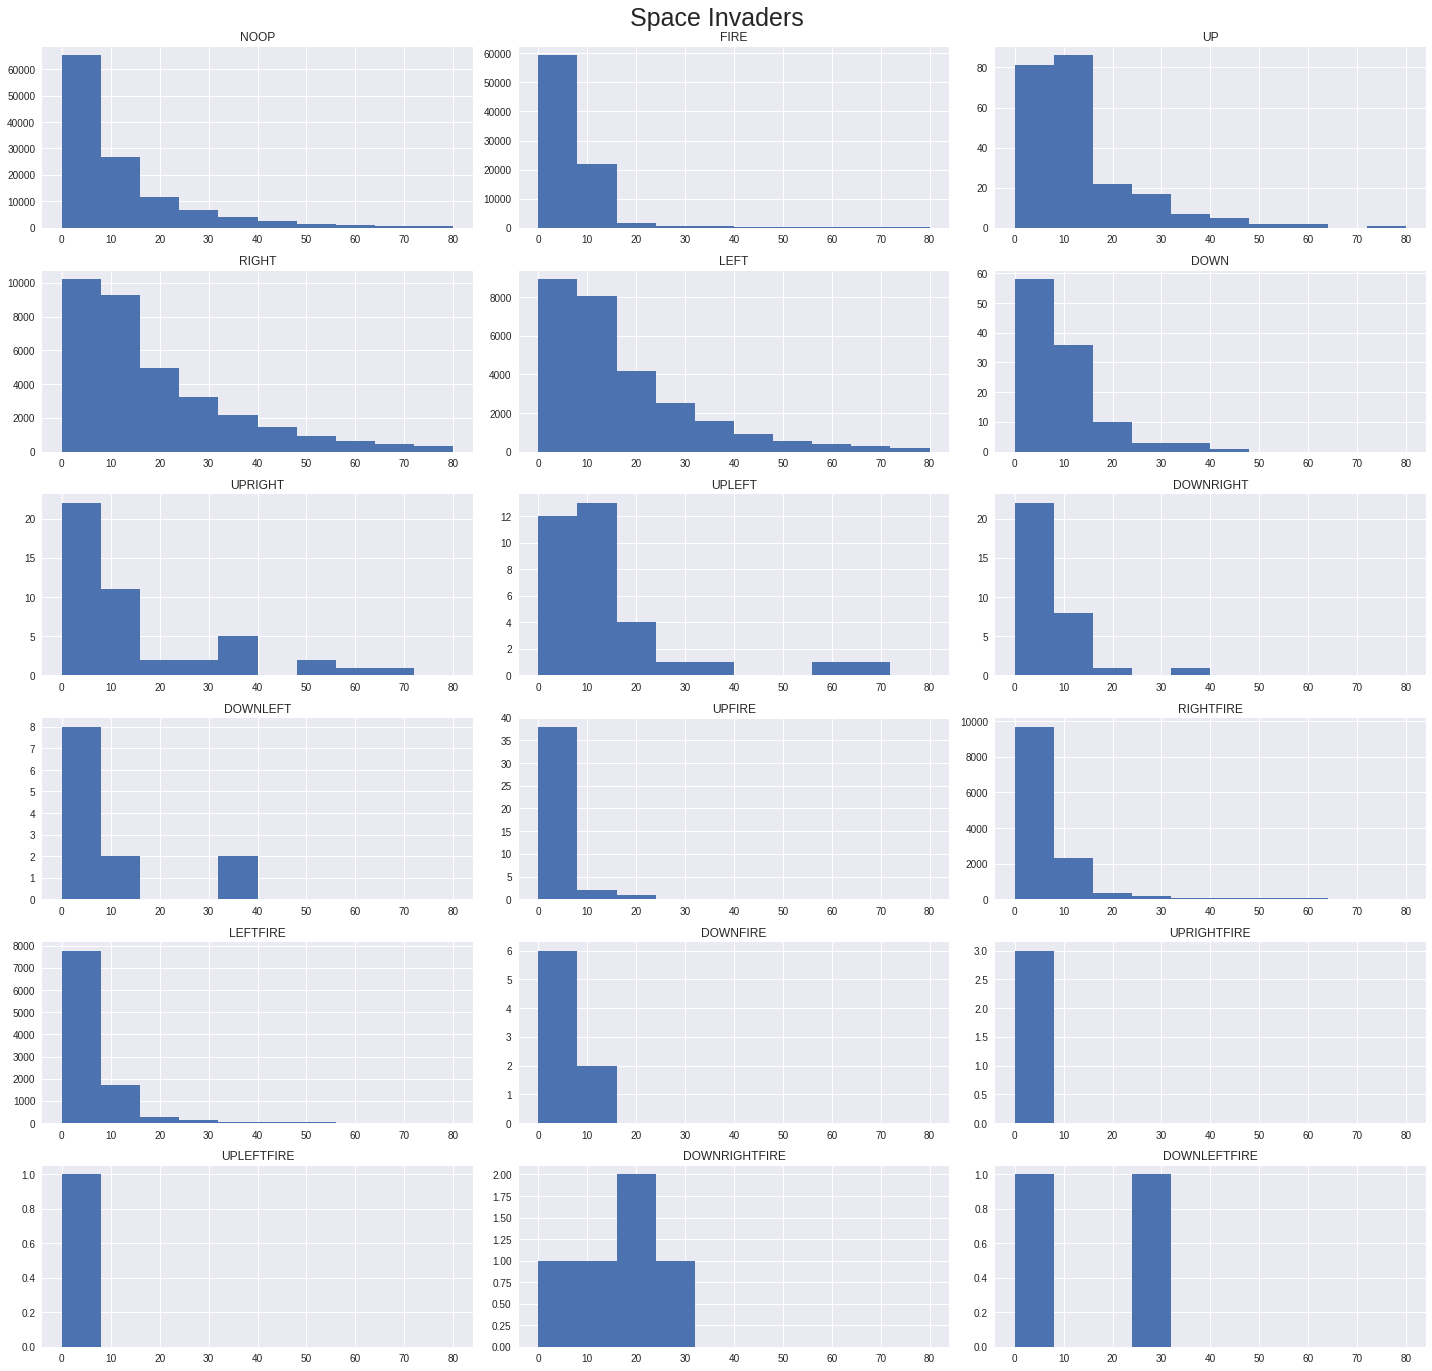

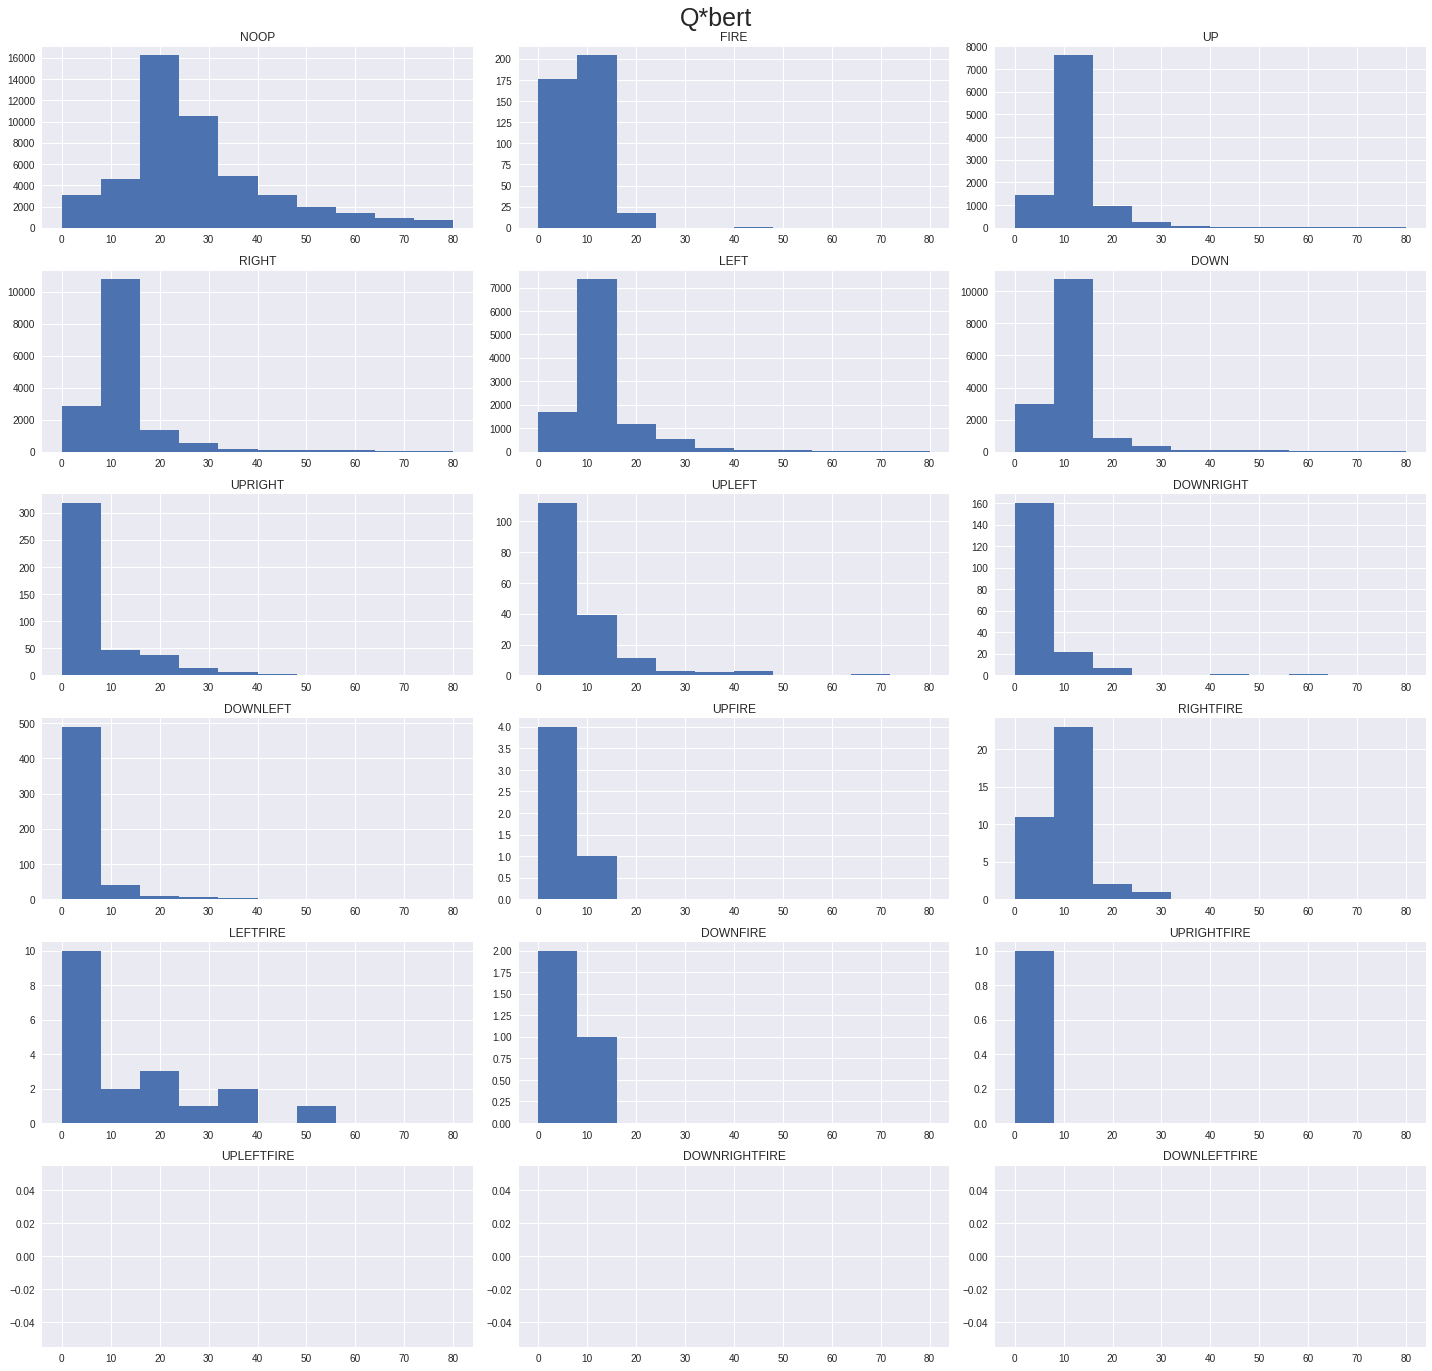

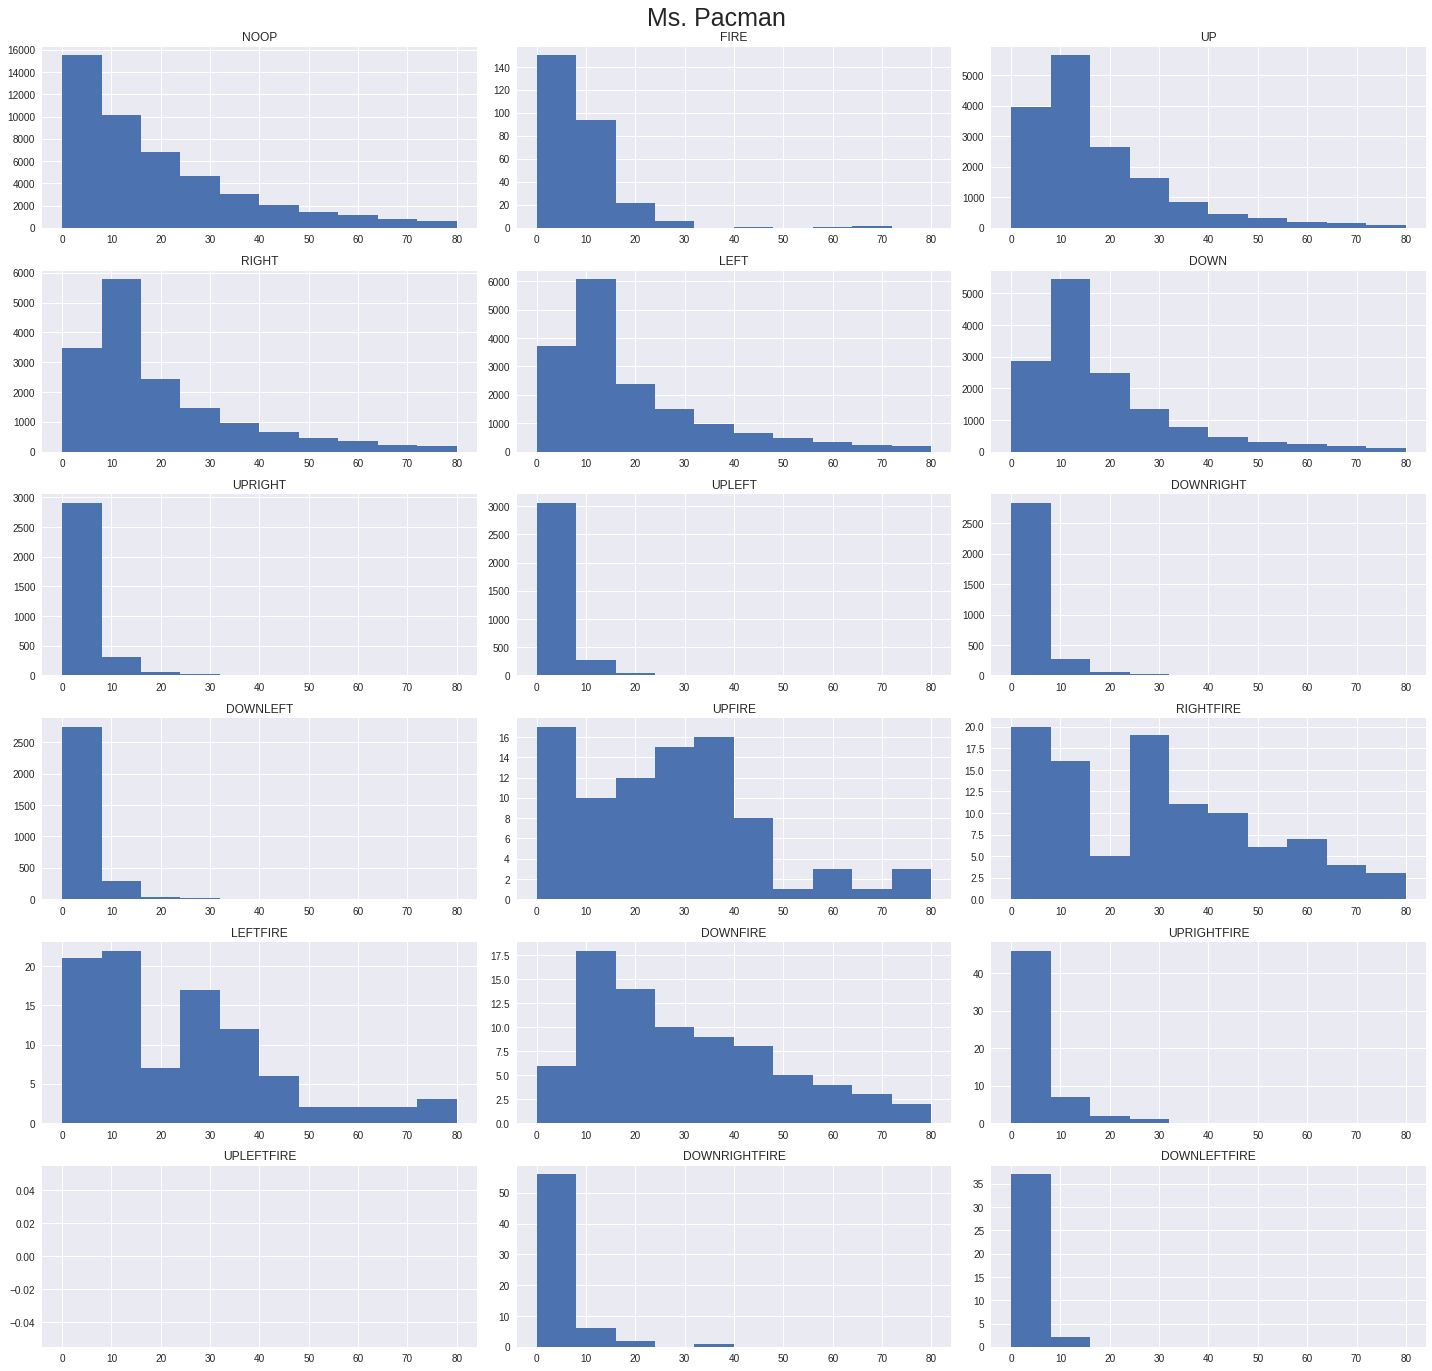

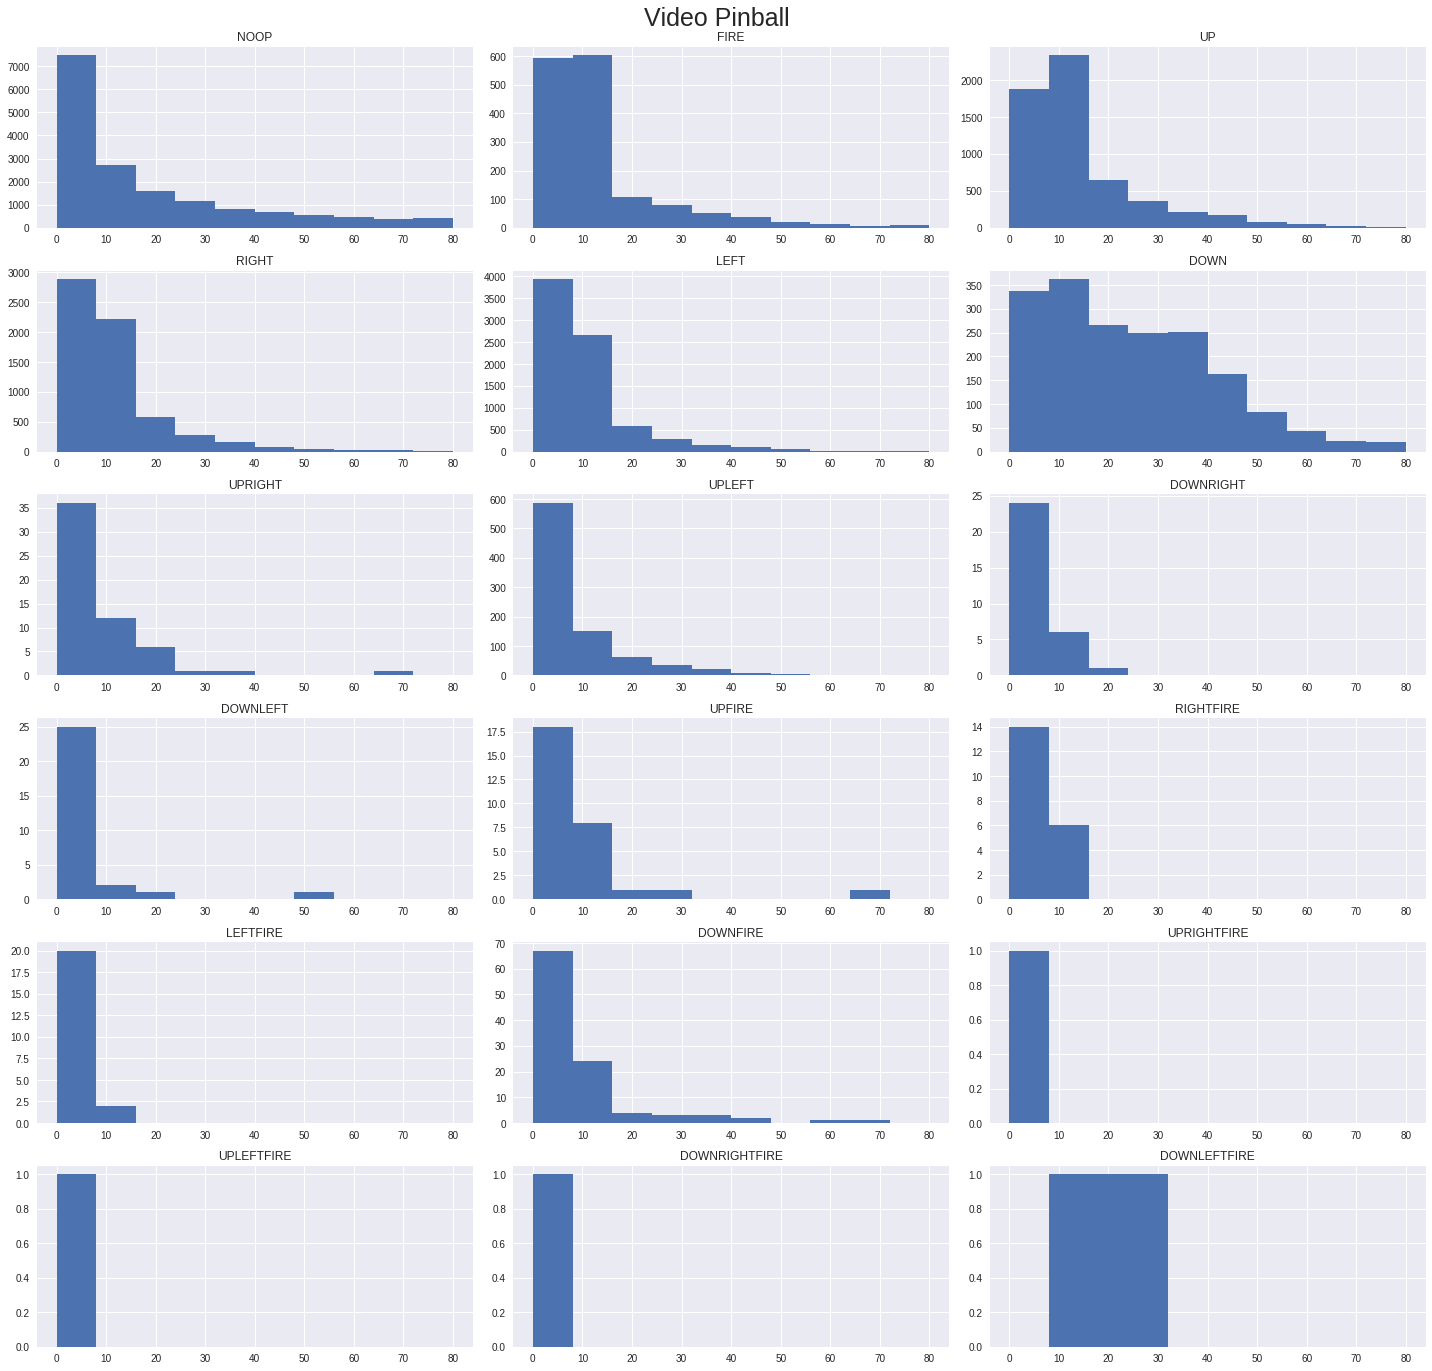

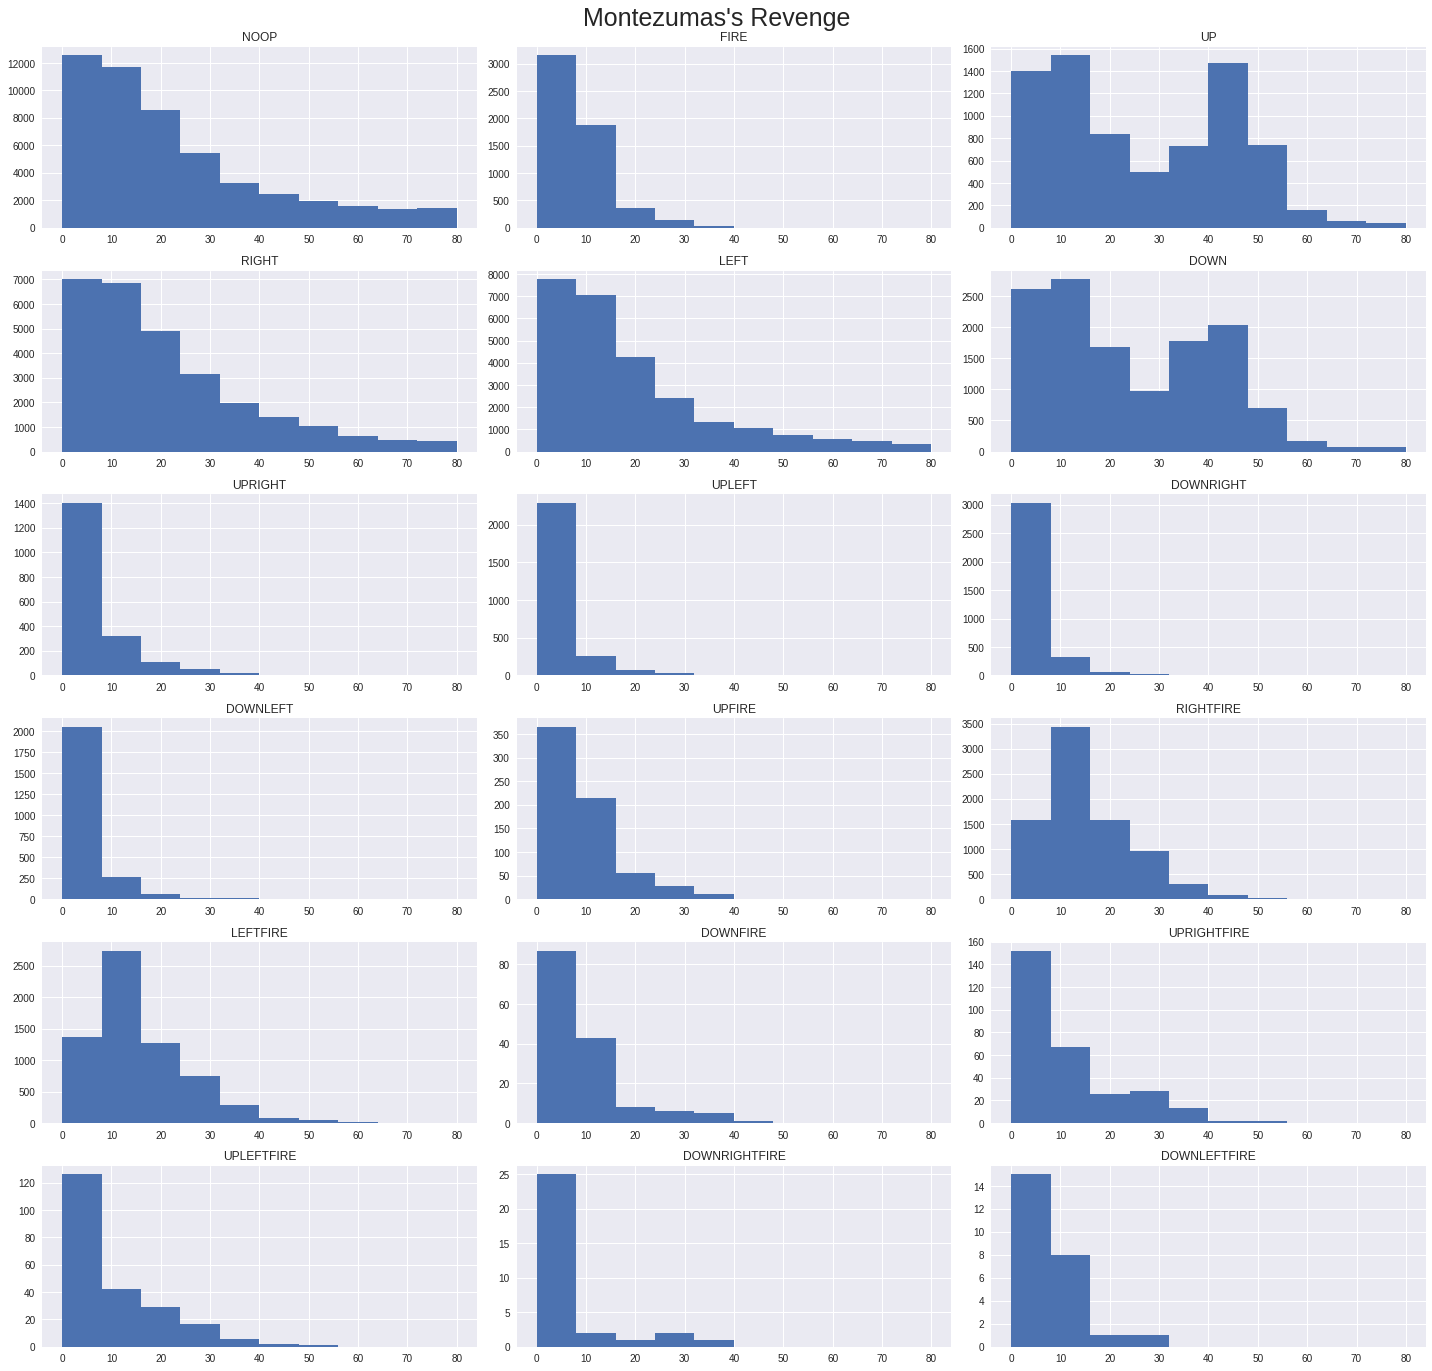

In [14]:
for g in util.GAMES:
    res = {}
    for i in range(18):
        res[i] = []
    for traj in actions[g]:
        splitted = action_splitter(traj)
        for s in splitted:
            if len(s) > 0:
                res[s[0]].append(len(s))
    f, ax = plt.subplots(6,3, figsize=(20,20))
    plt.suptitle(util.TITLES[g], fontsize=25)
    for i in range(18):
        ax[i//3, i%3].hist(res[i], range=[0,80]);
        ax[i//3,i%3].set_title(util.ACTIONS[i])
    plt.tight_layout(rect=[0, 0.03, 1, 0.97]);